In [38]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
from IPython.display import HTML
pylab.rcParams['figure.figsize'] = (10, 6)

In [57]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Stock Market Clustering

Firstly,we will import our data, which consists of the following two *.csv* files:

* **SP_500_firms.csv:** This file contains all firms currently included in the S&P 500 index.
* **SP_500_close_2015.csv:** This file contains daily stock price data of the firms listed in the previous file for 2015 (without some firms for which data was not available for the entire year).

After importing the data, we inspect the first observations for each dataframe.

In [6]:
# Load companies information
firms = pd.read_csv('SP_500_firms.csv', index_col = 0)
# Load companies stock prices
stockPrices = pd.read_csv('SP_500_close_2015.csv', index_col = 0)

In [63]:
firms.iloc[:5, :]

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology


In [64]:
stockPrices.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
Date,,,,,
2015-01-02,156.678596,43.160459,61.986410,86.129228,19.765196
2015-01-05,153.145069,43.170070,60.819874,84.674997,19.490271
2015-01-06,151.511999,42.679830,60.518833,84.064223,19.126976
2015-01-07,152.610267,43.025880,62.964797,85.828689,18.714587
2015-01-08,156.267949,43.910238,63.623323,87.137495,18.901144


## The main part 

### 1. Stock returns

#### Daily returns

In order to analyse how similar those companies perform, we will look at their daily stock price movements. We will assume that companies that have similar stock price movements from day to day, perform similarly. To calculate the daily returns for all stocks in the data we define function `stockReturns` which takes as input the dataframe of the stock prices and returns a dataframe with the daily returns of those stocks. The daily returns are calculated based on the following formula:

$$x_t = \frac{p_t - p_t-1}{p_t-1}$$

In [20]:
def stockReturns(priceDF):
    
    compTickers = priceDF.columns[0: ]    
    priceMat = priceDF.loc[ : , compTickers].as_matrix()    
    diffMat = (priceMat[1: ] - priceMat[ :-1]) / priceMat[ :-1]
    
    return pd.DataFrame(data = diffMat, index = priceDF.index[1: ], \
                        columns = compTickers)    

In [21]:
dailyReturns = stockReturns(stockPrices)
dailyReturns.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
Date,,,,,
2015-01-05,-0.022553,0.000223,-0.018819,-0.016884,-0.013910
2015-01-06,-0.010664,-0.011356,-0.004950,-0.007213,-0.018640
2015-01-07,0.007249,0.008108,0.040417,0.020989,-0.021561
2015-01-08,0.023967,0.020554,0.010459,0.015249,0.009969
2015-01-09,-0.012284,-0.010508,-0.027355,-0.001113,-0.018182


The daily returns of the stocks can be shown in the following figure:

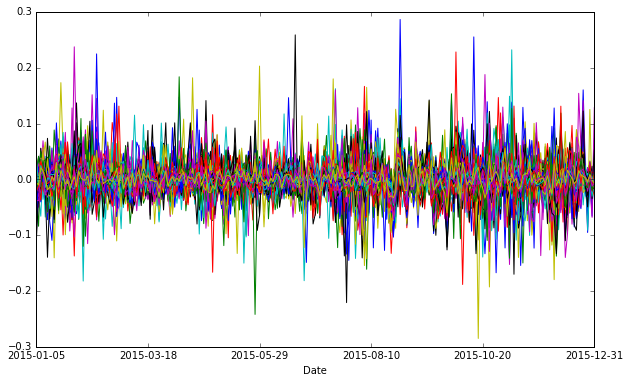

In [67]:
dailyReturns.plot(legend = False);

Next, we will find which companies experienced the **maximum** and **minimum** daily returns,  and what potential evidence there may be for those extreme returns.

To do so, we will marge the daily returns of all companies in one column and then sort this column in descending order.

In [9]:
dailyReturns['Date'] = dailyReturns.index
# Melt data frame so each row is one price change observation
dailyReturnsMelted = pd.melt(dailyReturns, id_vars = "Date")
dailyReturnsMelted = dailyReturnsMelted.rename(columns = {
    'variable':'Symbol',
    'value':'Price Change'
})
# Sort melted dataframe in descending order of price change
dailyReturnsSorted = dailyReturnsMelted.sort_values(by = 'Price Change', \
                                                    ascending = False)
# Merge on firm data with the symbol as the key
dailyReturnsSorted = dailyReturnsSorted.merge(firms, left_on = 'Symbol', \
                                              right_index = True, how = 'left')

The **maximum** daily returns for 2015 were the following:

In [69]:
dailyReturnsSorted.iloc[:10, :]

,Date,Symbol,Price Change,Name,Sector
49359,2015-08-27,FCX,0.286616,Freeport-McMoran Cp & Gld,Materials
121098,2015-06-22,WMB,0.258999,Williams Cos.,Energy
110887,2015-10-14,TRIP,0.255361,TripAdvisor,Consumer Discretionary
53731,2015-01-29,HAR,0.237600,Harman Int'l Industries,Consumer Discretionary
92330,2015-11-06,QRVO,0.232254,Qorvo,Information Technology
121923,2015-10-02,WYNN,0.228389,Wynn Resorts Ltd,Consumer Discretionary
110718,2015-02-12,TRIP,0.224915,TripAdvisor,Consumer Discretionary
57579,2015-05-29,HUM,0.203128,Humana Inc.,Health Care
64457,2015-10-21,KLAC,0.187895,KLA-Tencor Corp.,Information Technology
86408,2015-04-08,PRGO,0.183899,Perrigo,Health Care


Potential evidence for some of the **maximum** daily returns presented above can be found on the following links:

* Trip advisor: http://fortune.com/2015/10/14/tripadvisor-stock-gain-priceline-deal/
* Williams: http://www.forbes.com/sites/antoinegara/2015/06/22/pipeline-giant-williams-rejects-64-a-share-takeover-bid-from-energy-transfer/#318056c339f8
* Harman: http://investor.harman.com/releasedetail.cfm?releaseid=890984 and http://investor.harman.com/releasedetail.cfm?releaseid=893546 
* Qorvo: http://www.qorvo.com/news/2015/qorvo-announces-proposed-1-billion-senior-notes-offering and http://www.bizjournals.com/triad/news/2015/11/06/qorvo-revenue-rises-in-latest-quarter.html

The **minimum** daily returns for 2015 were the following:

In [70]:
dailyReturnsSorted.iloc[-10:, :]

,Date,Symbol,Price Change,Name,Sector
3720,2015-10-28,AKAM,-0.167306,Akamai Technologies Inc,Information Technology
70243,2015-11-09,MNK,-0.169981,Mallinckrodt Plc,Health Care
82309,2015-12-04,NRG,-0.179581,NRG Energy,Utilities
74667,2015-06-26,MU,-0.181515,Micron Technology,Information Technology
88624,2015-02-04,RL,-0.182169,Polo Ralph Lauren Corp.,Consumer Discretionary
123683,2015-10-07,YUM,-0.188324,Yum! Brands Inc,Consumer Discretionary
103364,2015-10-23,SRCL,-0.192767,Stericycle Inc,Industrials
17458,2015-07-24,BIIB,-0.220802,BIOGEN IDEC Inc.,Health Care
74143,2015-05-27,KORS,-0.241954,Michael Kors Holdings,Consumer Discretionary
92817,2015-10-16,PWR,-0.285006,Quanta Services Inc.,Industrials


Potential evidence for some of the **minimum** daily returns presented above can be found on the following links:

* Akami: http://www.fool.com/investing/general/2015/10/28/why-akamai-technologies-inc-fell-hard-on-wednesday.aspx
* Millinckrodt: http://www.bloomberg.com/news/articles/2015-11-09/mallinckrodt-slumps-on-scrutiny-from-valeant-foe-citron-research
* NRG Energy: http://247wallst.com/infrastructure/2015/12/04/nrg-continues-to-fall-as-ceo-steps-down/
* Micron: http://marketrealist.com/2015/06/microns-share-price-fall-19-june-26/
* Yum: http://www.reuters.com/article/us-yum-brands-china-idUSKCN0S11SZ20151007
* Michael Kors: http://money.cnn.com/2015/05/27/investing/michael-kors-earnings-stock-drop/

#### Yearly returns

Next, we will look at the overall performance of the S&P 500 companies over the whole year. Same as before, we create the function `yearlyStockReturns` which takes as input the dataframe of the stock prices and returns a dataframe with the yearly returns of those stocks.

In [10]:
def yearlyStockReturns(priceDF):
    priceMatrix = priceDF.as_matrix()
    # Calculate the yearly returns:
    # (final price - start price) / start price
    TotalPriceChangeMatrix = (priceMatrix[-1: ] - priceMatrix[ :1]) \
                              / priceMatrix[ :1]
    # Convert the result to a dataframe 
    # with the correct index and column names
    TotalPriceChangeDF = pd.DataFrame(TotalPriceChangeMatrix, \
                                      columns = priceDF.columns)
    # Transpose dataframe
    TotalPriceChangeDFtransposed = TotalPriceChangeDF.transpose()
    TotalPriceChangeDFtransposed.columns = ['Price Change']
    
    return TotalPriceChangeDFtransposed

To find which companies performed overall best and worst over the year we will sort the yearly returns of all companies in descending order.

In [11]:
yearlyReturns = yearlyStockReturns(stockPrices)

# Sort them
yearlyReturnsSorted = yearlyReturns.sort_values(by='Price Change', ascending=False)
# Merge on firm data with the symbol as the key (index in both dfs)
yearlyReturnsSorted = yearlyReturnsSorted.merge(firms, left_index=True, right_index=True, how='left')

The companies that performed **best** over the year are the following:

In [73]:
yearlyReturnsSorted.head(10)

,Price Change,Name,Sector
NFLX,1.294549,Netflix Inc.,Information Technology
AMZN,1.190750,Amazon.com Inc,Consumer Discretionary
ATVI,0.942684,Activision Blizzard,Information Technology
AYI,0.676443,Acuity Brands Inc,Industrials
NVDA,0.664514,Nvidia Corporation,Information Technology
GPN,0.600933,Global Payments Inc,Information Technology
HRL,0.559016,Hormel Foods Corp.,Consumer Staples
EXR,0.544469,Extra Space Storage,Financials
VRSN,0.527540,Verisign Inc.,Information Technology
RAI,0.497837,Reynolds American Inc.,Consumer Staples


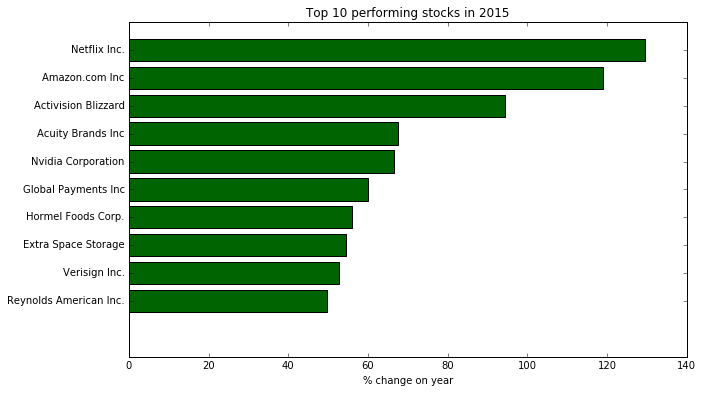

In [74]:
y_pos_top_10 = np.arange(len(yearlyReturnsSorted['Name'][:10])-1,-1,-1)
plt.barh(y_pos_top_10, yearlyReturnsSorted['Price Change'][:10]*100,
         align='center', color='darkgreen')
plt.yticks(y_pos_top_10, yearlyReturnsSorted['Name'][:10])
plt.xlabel("% change on year")
plt.title("Top 10 performing stocks in 2015");

The companies that performed **worst** over the year are the following:

In [75]:
yearlyReturnsSorted.tail(10)

,Price Change,Name,Sector
WYNN,-0.516602,Wynn Resorts Ltd,Consumer Discretionary
MUR,-0.538541,Murphy Oil,Energy
MRO,-0.546383,Marathon Oil Corp.,Energy
RRC,-0.553864,Range Resources Corp.,Energy
NRG,-0.559234,NRG Energy,Utilities
MU,-0.592518,Micron Technology,Information Technology
KMI,-0.632032,Kinder Morgan,Energy
FCX,-0.703792,Freeport-McMoran Cp & Gld,Materials
SWN,-0.738314,Southwestern Energy,Energy
CHK,-0.769785,Chesapeake Energy,Energy


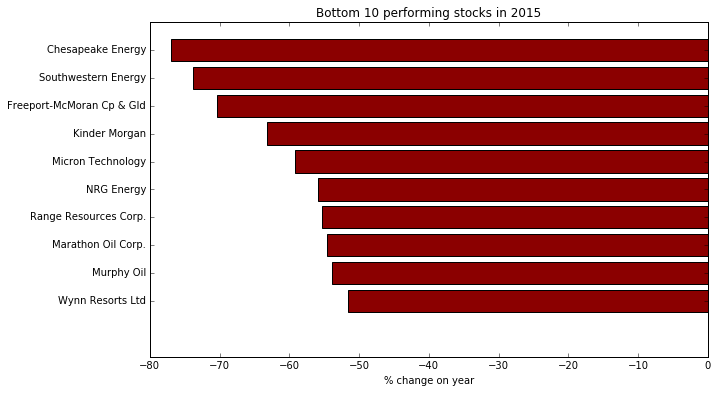

In [76]:
y_pos_top_10 = np.arange(len(yearlyReturnsSorted['Name'][-10:]))
plt.barh(y_pos_top_10, yearlyReturnsSorted['Price Change'][-10:]*100,
         align='center', color='darkred')
plt.yticks(y_pos_top_10, yearlyReturnsSorted['Name'][-10:])
plt.xlabel("% change on year")
plt.title("Bottom 10 performing stocks in 2015");

#### Volatility

Finally, we will try to figure out which companies exhibited **most** and **least** volatility. The volatility of the companies is measured based on the standard deviation of their daily returns over the year. We create the function `volatility` which takes as input a dataframe with the daily returns of the companies and returns a dataframe with the volatility measure of those companies, as defined above.

In [52]:
def volatility(dailyReturns):
    ##calculate sds and change into panda dataframe
    sdPriceChangeDF = pd.DataFrame(np.std(dailyReturns, axis = 0), \
                                   columns = ['Standard Deviation'])
    
    return sdPriceChangeDF

Next we sort the dataframe of the volatilities in order to find the most and least volatile companies for 2015.

In [53]:
sdPriceChangeDF = volatility(dailyReturns)

# Sort on standard deviation
sdPriceChangeDFsorted = sdPriceChangeDF.sort_values(by = 'Standard Deviation', \
                                                    ascending = False)
# Merge on firm data with the symbol as the key (index in both dfs)
sdPriceChangeDFsortedfull = sdPriceChangeDFsorted.merge(firms, \
                                                        left_index = True, \
                                                        right_index = True, \
                                                        how = 'left')

The **most volatile** companies for 2015 were the following:

In [79]:
sdPriceChangeDFsortedfull.head(10)

,Standard Deviation,Name,Sector
FCX,0.043983,Freeport-McMoran Cp & Gld,Materials
CHK,0.042699,Chesapeake Energy,Energy
RIG,0.037479,Transocean,Energy
SWN,0.035129,Southwestern Energy,Energy
WYNN,0.034848,Wynn Resorts Ltd,Consumer Discretionary
QRVO,0.033406,Qorvo,Information Technology
MNK,0.032508,Mallinckrodt Plc,Health Care
WMB,0.032159,Williams Cos.,Energy
RRC,0.032108,Range Resources Corp.,Energy
NFLX,0.031911,Netflix Inc.,Information Technology


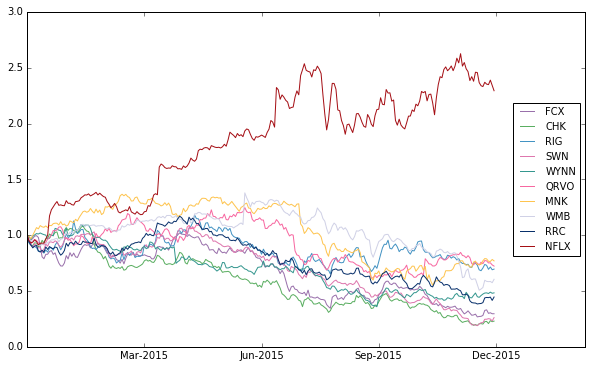

In [54]:
## create list of company ticker names that are in the top 10 most variable
columnlist = sdPriceChangeDFsortedfull[0:10].index.values.tolist()
##create data frame of price data for just the top 10 most variable companies
variablePriceData = stockPrices[columnlist]
##scale based on first price
variablePricesScaled = variablePriceData.divide(stockPrices[columnlist].ix[0])
y_pos_dates = np.arange(len(variablePricesScaled.index))
##Set colour scheme
colors = ['#9970ab','#5aae61','#4393c3','#de77ae','#35978f','#f768a1','#fec44f','#d0d1e6','#08306b','#a50f15']

for i in range(0,len(columnlist)):
    plt.plot(y_pos_dates,variablePricesScaled[columnlist[i]], c=colors[i], label=columnlist[i].format(i=i))
plt.legend(loc='best')
plt.xticks([len(variablePricesScaled.index)/4,
            len(variablePricesScaled.index)*2/4,
            len(variablePricesScaled.index)*3/4,
            len(variablePricesScaled.index)],
           ["Mar-2015","Jun-2015","Sep-2015","Dec-2015"])
plt.legend(loc=5,prop={'size':10})
plt.show();

The **least volatile** companies for 2015 were the following:

In [55]:
sdPriceChangeDFsortedfull.tail(10)

,Standard Deviation,Name,Sector
PG,0.010086,Procter & Gamble,Consumer Staples
RSG,0.009953,Republic Services Inc,Industrials
VZ,0.009929,Verizon Communications,Telecommunications Services
T,0.009923,AT&T Inc,Telecommunications Services
DVA,0.009863,DaVita Inc.,Health Care
CLX,0.009706,The Clorox Company,Consumer Staples
PEP,0.009693,PepsiCo Inc.,Consumer Staples
AJG,0.009691,Arthur J. Gallagher & Co.,Financials
CHD,0.009579,Church & Dwight,Consumer Staples
KO,0.009045,The Coca Cola Company,Consumer Staples


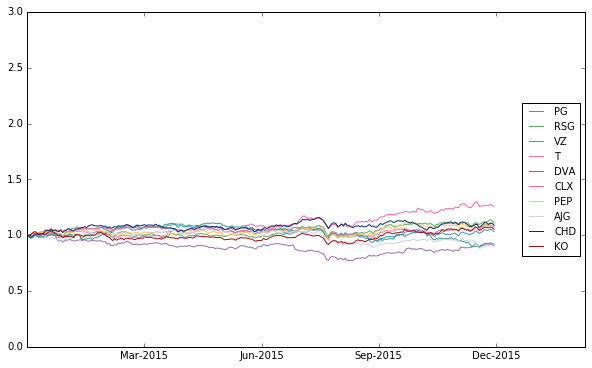

In [82]:
## create list of company ticker names that are in the top 10 most variable
columnlist = sdPriceChangeDFsortedfull[-10:].index.values.tolist()
##create data frame of price data for just the top 10 most variable companies
variablePriceData = stockPrices[columnlist]
##scale based on first price
variablePricesScaled = variablePriceData.divide(stockPrices[columnlist].ix[0])
y_pos_dates = np.arange(len(variablePricesScaled.index))
##Set colour scheme
colors = ['#9970ab','#5aae61','#4393c3','#de77ae','#35978f','#f768a1','#fec44f','#d0d1e6','#08306b','#a50f15']

for i in range(0,len(columnlist)):
    plt.plot(y_pos_dates,variablePricesScaled[columnlist[i]], c=colors[i], label=columnlist[i].format(i=i))
plt.legend(loc='best')
plt.xticks([len(variablePricesScaled.index)/4,
            len(variablePricesScaled.index)*2/4,
            len(variablePricesScaled.index)*3/4,
            len(variablePricesScaled.index)],
           ["Mar-2015","Jun-2015","Sep-2015","Dec-2015"])
plt.legend(loc=5,prop={'size':10})
axes = plt.gca()
axes.set_ylim([0,3])
plt.show();

### 2. Correlations

To find the similarities between stock price movements for different companies, we will calculate the correlation between the returns of different stock prices. For two companies with stock price returns $x, y$ and observations for $n$ days, their correlation is given by the following formula:

$$r_{xy} = \frac{n\sum x_i y_i - \sum x_i \sum y_i}{\sqrt{n\sum x_i^2 - (\sum x_i)^2} \sqrt{n\sum y_i^2 - (\sum y_i)^2}}$$

In order to compute the correlation of the companies, we define function `calCorrelations`, which takes as input a dataframe with the daily returns of the S&P 500 companies and returns their correlations in two different formats:

1. A **correlations matrix**, where each element represents the correlation betwwen the two companies indicated by the specific row and column. 
2. A **graph** where each node represents a company and each edge between two nodes represent the correlation between those two companies.

In [17]:
def calCorrelations(dailyReturn):
    col = dailyReturn.columns
    ncol = len(col)
    corrMat = np.identity(ncol)
    
    G = nx.Graph()
    G.add_nodes_from(col.values)
        
    n = len(dailyReturn)
    for i in range(0, ncol):
        for j in range(i + 1, ncol):
            x = dailyReturn[col[i]]
            y = dailyReturn[col[j]]
            xsum = sum(x)
            ysum = sum(y)
            corrMat[i][j] = (n * sum(x * y) - xsum * ysum) / (np.sqrt(n * sum(x**2) - xsum**2) * np.sqrt(n * sum(y**2) - ysum**2))
            corrMat[j][i] = corrMat[i][j]
            G.add_edge(col[i], col[j], weight = corrMat[i][j])
        
    return pd.DataFrame(data = corrMat, index = col, columns = col), G

In [23]:
corMatrix = calCorrelations(stockReturns(stockPrices))[0]
corMatrix.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
MMM,1.000000,0.598666,0.322637,0.632059,0.418550
ABT,0.598666,1.000000,0.483669,0.644081,0.434370
ABBV,0.322637,0.483669,1.000000,0.318051,0.226868
ACN,0.632059,0.644081,0.318051,1.000000,0.462545
ATVI,0.418550,0.434370,0.226868,0.462545,1.000000


In addition, in order to be able to find and print correlations easily between companies, we provide the following helper functions:

1. `cal2CompCor`: It takes as inputs the correlation matrix of the companies, the dataframe with the companies information and the symbols of two companies. It returns their full names and correlation.
2. `calTopLow5`: It takes as inputs the correlation matrix of the companies and the sumbol of a company. It returns the symbols and correaltions of the five highest and lowest correlated companies.

In [36]:
def cal2CompCor(correlationmatrix, firms, company1, company2):
    print("The correlation between " + firms.loc[(company1, company2), :].iloc[0, 0] + \
          " and " + firms.loc[(company1, company2), :].iloc[1, 0] + " is " + \
          str(corMatrix.loc[company1, company2]) + ".")

In [37]:
def highLowCorrelation(correlationmatrix, company):
    namesDict = dict()
    input_file = csv.DictReader(open('SP_500_firms.csv'))
    for row in input_file:
        #print(row)
        namesDict[row['Symbol']] = [row['Name'],row['Sector']]
    
    i = correlationmatrix.columns.get_loc(company)  
    j = correlationmatrix.ix[ : , i]
    high = j.nlargest(6)
    highindex = high.index
    listofhighcomp = []    
    for k in highindex:
        listofhighcomp.append(namesDict[k])
    low = j.nsmallest(5)
    lowindex = low.index
    listoflowcomp = []    
    for k in lowindex:
        listoflowcomp.append(namesDict[k])
       
    dflistofhighcomp = DataFrame(listofhighcomp)
    dfhighindex = DataFrame(highindex)
    dflistofhighcomp = dflistofhighcomp.merge(dfhighindex,right_index=True, left_index=True, how = 'left')
    dfhigh = DataFrame(high)
    table2 = dfhigh.merge(dflistofhighcomp, left_index = True, right_on='0_y', how = 'left')    
    table2.index = table2['0_y'].as_matrix()
    del table2['0_y']
    table2 = table2.rename(columns={company: 'Correlation', '0_x': 'Name of Company', 1: 'Industry'})

    dflistoflowcomp = DataFrame(listoflowcomp)
    dflowindex = DataFrame(lowindex)
    dflistoflowcomp = dflistoflowcomp.merge(dflowindex,right_index=True, left_index=True, how = 'left')
    dflow = DataFrame(low)
    table = dflow.merge(dflistoflowcomp, left_index = True, right_on='0_y', how = 'left')
    table.index = table['0_y'].as_matrix()
    del table['0_y']
    table = table.rename(columns={company: 'Correlation', '0_x': 'Name of Company', 1: 'Industry'})

    return(table2[1:], table)

We will use the functions defined above to explore some of the companies in the tech sector, like *Amazon*, *Microsoft*, *Facebook*, *Apple*, and *Google*. All stocks are affected by macroeconomic environments and thus are correlated with each other, either positively or negatively. There are various factors which determine how correlated two stocks are. 

Usually, stock prices of two companies from the same industry would move in tandem with each other as the market conditions would affect them both in the same way. However, there could alsob be cases when the market conditions would have different effects on companies in the same industry. Another determinent of stock correlation is whether they are value stocks or growth stocks. Stocks from Apple and Microsoft are considered to be value stocks as the companies themselves have relatively stable earnings and are not growing at a very fast rate. The other three (Amazon, Facebook and Google) are considered to be growth stocks and have higher P/E and high price-to-book ratios. In general, value stocks tend to move in conjunction with value stocks, and this phenomenon can also be observed with growth stocks.

In [40]:
highLowCorrelation(corMatrix, 'AMZN')

(       Correlation       Name of Company                Industry
 GOOGL     0.585553  Alphabet Inc Class A  Information Technology
 GOOG      0.584337  Alphabet Inc Class C  Information Technology
 SBUX      0.571951       Starbucks Corp.  Consumer Discretionary
 V         0.560704             Visa Inc.  Information Technology
 MA        0.538708       Mastercard Inc.  Information Technology,
       Correlation      Name of Company                Industry
 SRCL     0.056451       Stericycle Inc             Industrials
 RIG      0.060162           Transocean                  Energy
 SWN      0.082376  Southwestern Energy                  Energy
 TRIP     0.087684          TripAdvisor  Consumer Discretionary
 WFM      0.090700   Whole Foods Market        Consumer Staples)

For the top five stocks correlated with Amazon's stocks, $4$ out of the $5$ companies are IT companies and are growth stocks, which is not surprising. However, Starbucks also happens to have a relatively high correlation with Amazon's stocks though it comes from a completely different industry. 

In [42]:
highLowCorrelation(corMatrix, 'MSFT')

(      Correlation            Name of Company                Industry
 MMC      0.604549           Marsh & McLennan              Financials
 PG       0.604204           Procter & Gamble        Consumer Staples
 MA       0.590886            Mastercard Inc.  Information Technology
 ADP      0.589445  Automatic Data Processing  Information Technology
 SBUX     0.583705            Starbucks Corp.  Consumer Discretionary,
       Correlation      Name of Company                Industry
 SRCL     0.028887       Stericycle Inc             Industrials
 NRG      0.090761           NRG Energy               Utilities
 RIG      0.113785           Transocean                  Energy
 SWN      0.114787  Southwestern Energy                  Energy
 URBN     0.128788     Urban Outfitters  Consumer Discretionary)

For Microsoft, $2$ out of the top $5$ correlated stocks are from the same industry. Though the other $3$ are from a different industry, they are considered to be value stocks.

In [41]:
highLowCorrelation(corMatrix, 'FB')

(       Correlation        Name of Company                Industry
 FISV      0.619667             Fiserv Inc  Information Technology
 MA        0.617659        Mastercard Inc.  Information Technology
 SBUX      0.598190        Starbucks Corp.  Consumer Discretionary
 GOOGL     0.586548   Alphabet Inc Class A  Information Technology
 TSS       0.580214  Total System Services  Information Technology,
      Correlation                   Name of Company   Industry
 NEM    -0.002832  Newmont Mining Corp. (Hldg. Co.)  Materials
 RIG     0.013327                        Transocean     Energy
 SWN     0.047667               Southwestern Energy     Energy
 DO      0.054310         Diamond Offshore Drilling     Energy
 CHK     0.058682                 Chesapeake Energy     Energy)

For Facebook, $4$ out of $5$ of the top correlated companies are in the IT industry. Starbucks also appears in the top 5 for Facebook, surprisingly.

In [43]:
highLowCorrelation(corMatrix, 'AAPL')

(      Correlation         Name of Company                Industry
 ITW      0.601265     Illinois Tool Works             Industrials
 NOC      0.589368  Northrop Grumman Corp.             Industrials
 HON      0.576730    Honeywell Int'l Inc.             Industrials
 FISV     0.573935              Fiserv Inc  Information Technology
 SWKS     0.573350      Skyworks Solutions  Information Technology,
      Correlation                   Name of Company                Industry
 RRC     0.112711             Range Resources Corp.                  Energy
 CMG     0.130501            Chipotle Mexican Grill  Consumer Discretionary
 NEM     0.143713  Newmont Mining Corp. (Hldg. Co.)               Materials
 RIG     0.144045                        Transocean                  Energy
 SWN     0.146811               Southwestern Energy                  Energy)

For Apple, surprisingly its top $3$ correlated stocks are all from the Industrials sector, with the subsequent $2$ being from the IT industry. These results are interesting, as the companies do not appear to have any relation to Apple.

Ref: http://www.cnbc.com/2015/09/09/the-crazy-stocks-that-correlate-with-apple.html

In [47]:
highLowCorrelation(corMatrix, 'GOOG')

(       Correlation       Name of Company                Industry
 GOOGL     0.989365  Alphabet Inc Class A  Information Technology
 AMZN      0.584337        Amazon.com Inc  Consumer Discretionary
 FB        0.569256              Facebook  Information Technology
 PGR       0.547913     Progressive Corp.              Financials
 MSFT      0.520563       Microsoft Corp.  Information Technology,
       Correlation            Name of Company                Industry
 SRCL     0.017149             Stericycle Inc             Industrials
 RIG      0.023044                 Transocean                  Energy
 DO       0.053734  Diamond Offshore Drilling                  Energy
 RRC      0.056774      Range Resources Corp.                  Energy
 URBN     0.067461           Urban Outfitters  Consumer Discretionary)

In [48]:
highLowCorrelation(corMatrix, 'GOOGL')

(      Correlation       Name of Company                Industry
 GOOG     0.989365  Alphabet Inc Class C  Information Technology
 FB       0.586548              Facebook  Information Technology
 AMZN     0.585553        Amazon.com Inc  Consumer Discretionary
 PGR      0.556862     Progressive Corp.              Financials
 MA       0.515583       Mastercard Inc.  Information Technology,
       Correlation            Name of Company     Industry
 RIG      0.009523                 Transocean       Energy
 RRC      0.043924      Range Resources Corp.       Energy
 DO       0.045733  Diamond Offshore Drilling       Energy
 SWN      0.062425        Southwestern Energy       Energy
 SRCL     0.062576             Stericycle Inc  Industrials)

Alphabet Inc. is the parent company of Google and has two types of stocks (`GOOG` and `GOOGL`), which are Class A and Class C share respectively. The difference between the two is that the owner of Class A share are allowed to vote, where as the owners of Class C shares are not. 
The top 5 correlated shares for `GOOG` and `GOOGL` are the same, aside from Microsoft for `GOOG` and Mastercard Inc for `GOOGL`. It is not surprising that the highest stock correlation for `GOOG` is `GOOGL` at 0.98 and vice versa, since they are under the same parent company.

Most of the lowest correlated stocks for each of the aforeentioned tech companies are from companies in the Energy/Industrials/Materials sector, whose stock prices move in conjunction with commodity prices such as oil and gas based on global supply and demand. Thus, it is not surprising that their stock prices have such low correlation with the stock prices of tech companies.

For the companies which appear to have no relation to the above tech companies but have correlated stocks, this may be due to chance, as the time period we are looking at is only a year. It would be interesting to see if this correlation is sustained throughout a longer time period, to see if there is really a correlation between the two stocks.

Something interesting to note is that there appears to be no stocks in the S&P 500 which are strongly negatively correlated with the stocks from above tech companies. 

### 3. Clustering algorithm

We will now use the similarity information of the companies based on their correlations to divide them into clusters. The clusters will indicate companies with similar performance over the year 2015 and will be performed using a *greedy* algorithm design which is described as follows:

1. Sort the edges in the graph by their weight (ie the correlation)
2. Create a single-node set from each node in the graph
3. Repeat k times:
    1. Pick the highest-weight edge
    2. Merge the sets containing the source and the destination of the edge
    3. Repeat from A. with the next-highest weight edge
    
4. Return the remaining sets

To perform the clustering, we define tweo new functions, `sortCorrelations` and `clusteringAlg`, that perform the following tasks:

* `sortCorrelations`: Takes as input the correlation matrix of the companies and returns an ordered list of tuples on descending order based on the correlations of the companies. Each tuple has the following format:

$$(correlation, company_1, company_2)$$

* `clusteringAlg`: takes as input the list of tuple created by the previous function and a constant $k$, which represents the iterations of the algorithm, and clusters the companies based on the algorithm described previously. The output of the function is a list of sets, where each set represents a cluster of companies and a list of integeres where each integer represents the number of clusters at each iteration.

In [167]:
def sortCorrelations(corMatrix):
    n = int(corMatrix.shape[0])
    corList = []
    for i in range(1, n):
        for j in range(0, i):
            corList.append((corMatrix.iloc[i, j], corMatrix.columns.values[i], \
                            corMatrix.columns.values[j]))
    return sorted(corList, reverse = True)

In [178]:
def clusteringAlg(corList, k = 0):
    """
    Input:  
    corList: The ordered list of tuples which include the
              correlations between firms and the firms themselves
    k: The number of iterations for the clustering algorithm
    Output: 
    A list of sets where each set represents an individual 
    cluster
    """
    # Initialize the list of sets. Each set represents a cluster
    # which initialy includes only one firm
    sets = []
    noOfClusters = []
    for i in range(len(corList)):
        if not({corList[i][1]} in sets):
            sets.append({corList[i][1]})
        if not({corList[i][2]} in sets):
            sets.append({corList[i][2]}) 
    
    # Repeat the algorithm k times
    # In each iteration we check the k-th tuple of correlations list
    # and whether the 2 firms in that tuple are already in the same
    # set. If they do, we move on to the next tuple, otherwise we merge
    for j in range(min(k, len(corList))):
        nd1 = corList[j][1]
        nd2 = corList[j][2]
        fl1, fl2 = False, False 
        noOfClusters.append(len(sets))
        for i in range(len(sets)):
            if (nd1 in sets[i]) and fl1 == False:
                idx1 = i
                fl1 = True
            if (nd2 in sets[i]) and fl2 == False:
                idx2 = i
                fl2 = True
        if idx1 != idx2:
            sets[idx1] = sets[idx1].union(sets[idx2])
            sets.remove(sets[idx2])
    # Return the final list of sets
    return sets, noOfClusters

In [198]:
corList = sortCorrelations(corMatrix)
corList[:10]

[(0.99999999998958444, 'TYC', 'JCI'),
 (0.98936504039463558, 'GOOG', 'GOOGL'),
 (0.97729617166665417, 'FOX', 'FOXA'),
 (0.97468754674730551, 'NWS', 'NWSA'),
 (0.95862253533172093, 'DISCK', 'DISCA'),
 (0.92459176248047714, 'STI', 'BBT'),
 (0.92183682101015096, 'STI', 'PNC'),
 (0.91872538690940486, 'STI', 'HBAN'),
 (0.91744693036104719, 'DTE', 'CMS'),
 (0.91668168527355165, 'MET', 'LNC')]

In [200]:
clusters, noClusters = clusteringAlg(corList, k = 2000)

In the following diagram we observe how the number of clusters decreases as the number of iterations increases from $1$ to $2000$. We observe that the slope of the line is more steep during the first iterations but as the number of iterations increases, the number of clusters decreases at a lowest pace. 

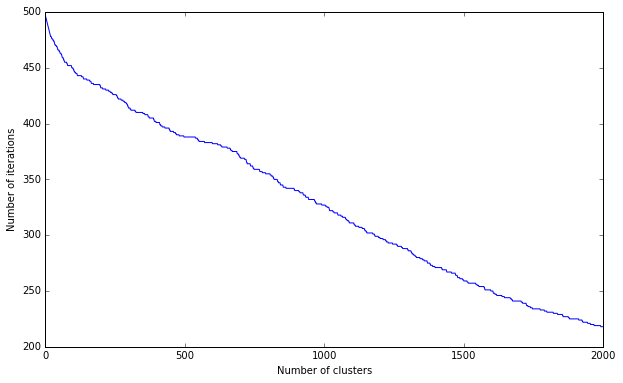

In [195]:
t = np.arange(1, 2001)
plt.plot(t, noClusters, '-')
plt.xlabel('Number of clusters')
plt.ylabel('Number of iterations')
plt.show()

#### To be filled:

* What is the greedy algorithm called?
* In what other graph problem is it often used? 
* How are the problems related?

In order to evaluate our clustering algorithm, we will focus on some of the resulting clusters and see if the stock prices and daily returns of the companies that are clustered together perform in a similar way. For that reason, we define the function `plotSetPrices` which takes as inputs the stock prices of the S&P 500 companies and a cluster of companies, which corresponds to one element of the list of sets, and plots the normalised prices for those companies.

In [215]:
def plotSetPrices(stockPrices, cluster):
    """
    Description:
    Plots the stock prices of a set of firms that belong to the same
    cluster
    Input:
    stockPrices: A dataframe that contains the prices of the stocks
    cluster: A set that contains all the names of the firms that belong
             at the same cluster
    """
    normPrices = stockPrices.loc[:, cluster]
    normPrices = normPrices / normPrices.iloc[0, :]
    normPrices.plot(legend = True);

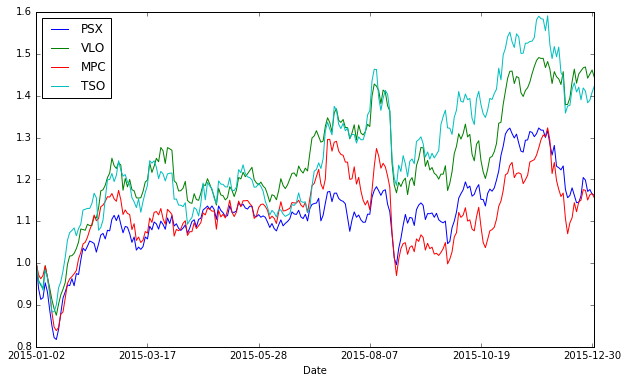

In [220]:
plotSetPrices(stockPrices, clusters[4])

## The extra part 

### In-depth analysis

### Exploring other clustering methods

# Notes

*Any notes or comments about the report to be listed here:*

* Turn some outputs into dataframes so they look better.
* 